# Estimation of the values of vehicle miles traveled (VMT)

In [1]:
#! pip install pmdarima

In [2]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# Load specific forecasting tools
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Data: Vehicle miles traveled (VMT) 
VMT plays important role in transportation planning. It measures the amount of travel for all vehicles in a geographic region over a given period of time. It is calculated as the sum of the number of miles traveled by each vehicle.

The data can be downloaded from: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

In [3]:
df = pd.read_csv('VMT.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.rename(columns={"TRFVOLUSM227NFWA":"vmt"}, inplace = True)
df.head()

,vmt
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


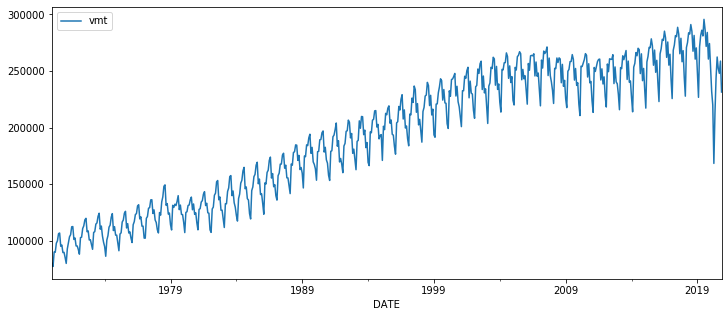

In [4]:
df['vmt'].plot(figsize = (12,5), legend=True)

#### Seasonal Decomposition of the time series df['vmt']

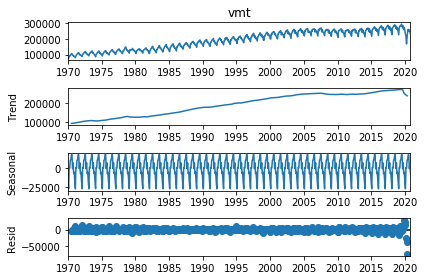

In [5]:
result = seasonal_decompose(df['vmt'], model='add')  # model='additive'
result.plot();

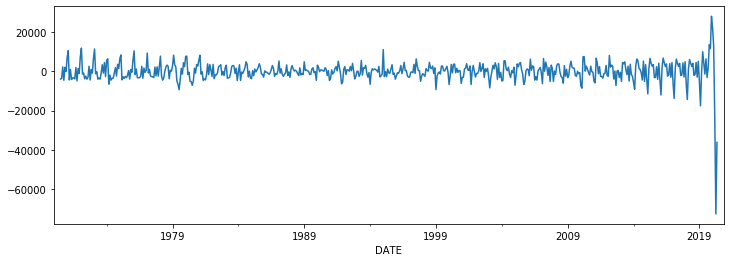

In [6]:
result.resid.plot(figsize=(12,4))

### Train-test split

In [7]:
len_df = len(df)
len_train = len_df - 36
train = df.iloc[:len_train]
test = df.iloc[len_train:]

### Feature scaling

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## LSTM model

Epoch 1/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0133
Epoch 2/20
551/551 [==============================] - ETA: 0s - loss: 0.007 - 6s 11ms/step - loss: 0.0071
Epoch 3/20
551/551 [==============================] - 7s 13ms/step - loss: 0.0052: 0
Epoch 4/20
551/551 [==============================] - 8s 14ms/step - loss: 0.0051: 0s - loss
Epoch 5/20
551/551 [==============================] - 6s 11ms/step - loss: 0.0049
Epoch 6/20
551/551 [==============================] - 6s 11ms/step - loss: 0.0036
Epoch 7/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0024
Epoch 8/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0024
Epoch 9/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0024
Epoch 10/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0020
Epoch 11/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0017
Epoch 12/20
551/551 [==============================] - 6s 

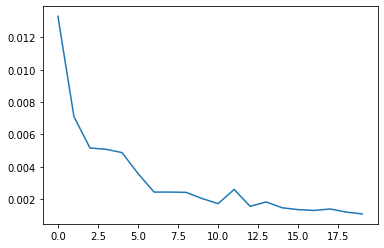

In [9]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=20)

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## SARIMA Model
Run pmdarima.auto_arima to obtain recommended orders

In [10]:
model_recommended = auto_arima(scaled_train,seasonal=True,m=12)
model_recommended.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  575
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                1642.546
Date:                            Mon, 22 Feb 2021   AIC                          -3275.093
Time:                                    00:30:19   BIC                          -3253.435
Sample:                                         0   HQIC                         -3266.637
                                            - 575                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5950      0.027    -22.215      0.000      -0.647      -0.542
ar.S.L12       0.1549      0.084      1.852      0.064      -0.009       0.319
ar.S.L24      -0.1105      0.059     -1.863      0.063      -0.227       0.006
ma.S.L12      -0.6631      0.080     -8.274      0.000      -0.820      -0.506
sigma2         0.0002   7.75e-06     21.886      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       87.82   Jarque-Bera (JB):               108.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
model_sarima = SARIMAX(scaled_train,order=model_recommended.order,seasonal_order=model_recommended.seasonal_order)
result_sarima = model_sarima.fit()

In [12]:
def predict_lstm(scaled_train, n_input, n_features, len_test):
    scaled_test_preds = []
    predictions_lstm = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len_test):

        current_pred = model.predict(current_batch)[0]
        scaled_test_preds.append(current_pred) 
        
        # update batch: drop first value, add prediction
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    
    predictions_lstm = scaler.inverse_transform(scaled_test_preds)
    
    return predictions_lstm

predictions_lstm = predict_lstm(scaled_train, n_input, n_features, len(test))
test['Predictions-LSTM'] = predictions_lstm

start=len(scaled_train)
end=len(scaled_train)+len(test)-1
scaled_test_preds = result_sarima.predict(start=start, end=end, dynamic=False, typ='levels')
predictions_sarima = scaler.inverse_transform(scaled_test_preds.reshape(-1,1))

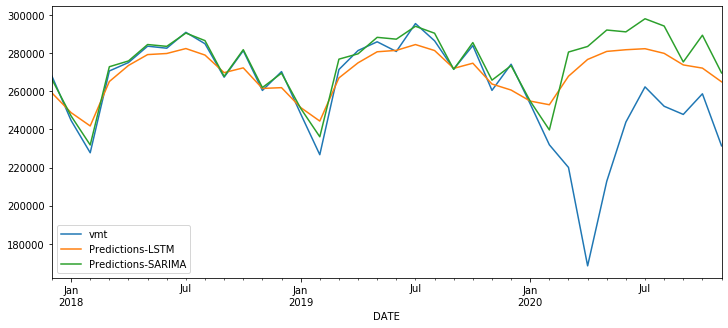

In [13]:
## Compare the performance of models
test['Predictions-SARIMA'] = predictions_sarima
test.plot(figsize=(12,5))

In [14]:
# 